## ***Exploratory Data Analysis & Preliminary Peak Assessment***

### **📌 Notebook Objective**

This notebook performs exploratory data analysis (EDA) on the Panama electricity load dataset to understand demand patterns, seasonal behavior, and external influences such as weather and calendar effects.

It also establishes a statistical definition of peak load, which forms the basis for downstream anomaly and overload detection.


### **📌 Dataset Description**

The dataset consists of hourly national electricity demand along with meteorological variables and calendar indicators.

Due to confidentiality of feeder-level data, national demand is used as a proxy, and the same modeling logic applies directly to feeder-level forecasting.

**Target Variable**
* nat_demand — national electricity demand (MWh)

**Explanatory Variables**
* Weather: temperature, humidity, precipitation, wind speed (multiple cities)
* Calendar: holidays, school periods

### **📌 Initial Observations**
* The dataset is continuous and uniformly sampled at hourly resolution
* Demand shows strong daily and weekly seasonality
* Clear demand deviations are observed during holidays and school vacations

These observations justify the inclusion of lagged demand, weather, and calendar features in forecasting models.

### **📌 Load Profile Analysis**

Hourly and daily load profiles reveal:
* Morning and evening demand peaks
* Reduced load during late-night hours
* Distinct weekend and weekday behavior

Such patterns are typical of real-world distribution networks and reinforce the relevance of short-term forecasting for operational planning.

### **📌 Impact of Holidays and School Periods**

Holiday and school indicators significantly affect electricity demand:
* Holidays often lead to abnormal demand spikes or drops
* School periods increase daytime load consistency

This confirms that calendar-based features are critical for accurate load prediction and peak identification.

### **📌 Preliminary Peak Load Definition**

Peak demand is initially defined using a statistical threshold approach, where load values above the 95th percentile are flagged as peaks.

This definition:
* Is data-driven
* Requires no manual labeling
* Provides a practical baseline for operational peak detection

These peak labels are used later to validate anomaly detection on forecast residuals.

**Importing Necessary Libraries**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8")

**Loading the Dataset**

In [ ]:
df = pd.read_csv(
    "continuous dataset.csv",
    parse_dates=["datetime"],
    index_col="datetime"
)

df.head()

,nat_demand,T2M_toc,QV2M_toc,TQL_toc,W2M_toc,T2M_san,QV2M_san,TQL_san,W2M_san,T2M_dav,QV2M_dav,TQL_dav,W2M_dav,Holiday_ID,holiday,school
datetime,,,,,,,,,,,,,,,,
2015-01-03 01:00:00,970.3450,25.865259,0.018576,0.016174,21.850546,23.482446,0.017272,0.001855,10.328949,22.662134,0.016562,0.096100,5.364148,0,0,0
2015-01-03 02:00:00,912.1755,25.899255,0.018653,0.016418,22.166944,23.399255,0.017265,0.001327,10.681517,22.578943,0.016509,0.087646,5.572471,0,0,0
2015-01-03 03:00:00,900.2688,25.937280,0.018768,0.015480,22.454911,23.343530,0.017211,0.001428,10.874924,22.531030,0.016479,0.078735,5.871184,0,0,0
2015-01-03 04:00:00,889.9538,25.957544,0.018890,0.016273,22.110481,23.238794,0.017128,0.002599,10.518620,22.512231,0.016487,0.068390,5.883621,0,0,0
2015-01-03 05:00:00,893.6865,25.973840,0.018981,0.017281,21.186089,23.075403,0.017059,0.001729,9.733589,22.481653,0.016456,0.064362,5.611724,0,0,0


**Dataset Overview**

In [ ]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 48048 entries, 2015-01-03 01:00:00 to 2020-06-27 00:00:00
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   nat_demand  48048 non-null  float64
 1   T2M_toc     48048 non-null  float64
 2   QV2M_toc    48048 non-null  float64
 3   TQL_toc     48048 non-null  float64
 4   W2M_toc     48048 non-null  float64
 5   T2M_san     48048 non-null  float64
 6   QV2M_san    48048 non-null  float64
 7   TQL_san     48048 non-null  float64
 8   W2M_san     48048 non-null  float64
 9   T2M_dav     48048 non-null  float64
 10  QV2M_dav    48048 non-null  float64
 11  TQL_dav     48048 non-null  float64
 12  W2M_dav     48048 non-null  float64
 13  Holiday_ID  48048 non-null  int64  
 14  holiday     48048 non-null  int64  
 15  school      48048 non-null  int64  
dtypes: float64(13), int64(3)
memory usage: 6.2 MB


,nat_demand,T2M_toc,QV2M_toc,TQL_toc,W2M_toc,T2M_san,QV2M_san,TQL_san,W2M_san,T2M_dav,QV2M_dav,TQL_dav,W2M_dav,Holiday_ID,holiday,school
count,48048.000000,48048.000000,48048.000000,48048.000000,48048.000000,48048.000000,48048.000000,48048.000000,48048.000000,48048.000000,48048.000000,48048.000000,48048.000000,48048.000000,48048.000000,48048.000000
mean,1182.868647,27.399111,0.018313,0.079979,13.391049,26.921023,0.017844,0.106265,7.046675,24.719513,0.016867,0.144681,3.567589,0.704795,0.062937,0.727793
std,192.068896,1.675462,0.001607,0.065589,7.295502,3.018129,0.001889,0.086293,4.103711,2.414019,0.001584,0.087899,1.710522,3.147470,0.242852,0.445100
min,85.192500,22.953455,0.012054,0.000000,0.008979,19.765222,0.010247,0.000009,0.060394,19.933740,0.009655,0.000032,0.015497,0.000000,0.000000,0.000000
25%,1020.056900,26.160455,0.017236,0.026451,7.544958,24.769281,0.016584,0.036819,3.955051,22.954652,0.015800,0.075775,2.298887,0.000000,0.000000,0.000000
50%,1168.427700,27.118051,0.018590,0.065201,12.182103,26.167352,0.018351,0.085968,5.992762,24.001718,0.017167,0.130188,3.413994,0.000000,0.000000,1.000000
75%,1327.563950,28.558344,0.019521,0.117310,18.661282,28.712335,0.019242,0.157288,9.409871,26.243402,0.018067,0.200012,4.670628,0.000000,0.000000,1.000000
max,1754.882000,35.039575,0.022690,0.521240,39.229726,39.063440,0.022165,0.484985,24.483937,34.216211,0.021066,0.477783,10.288902,22.000000,1.000000,1.000000


**Overall Load Profile**

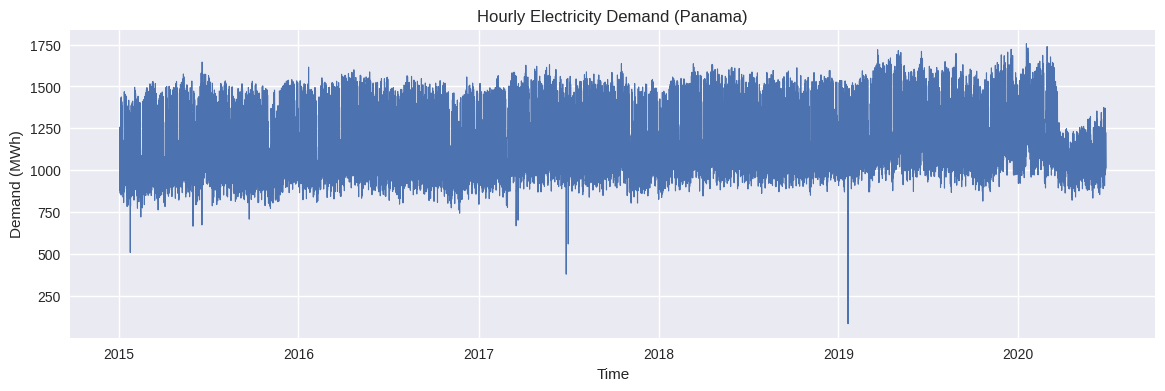

In [ ]:
plt.figure(figsize=(14,4))
plt.plot(df["nat_demand"], linewidth=0.8)
plt.title("Hourly Electricity Demand (Panama)")
plt.xlabel("Time")
plt.ylabel("Demand (MWh)")
plt.show()

**Holiday vs. Non-Holiday Load Comparison**

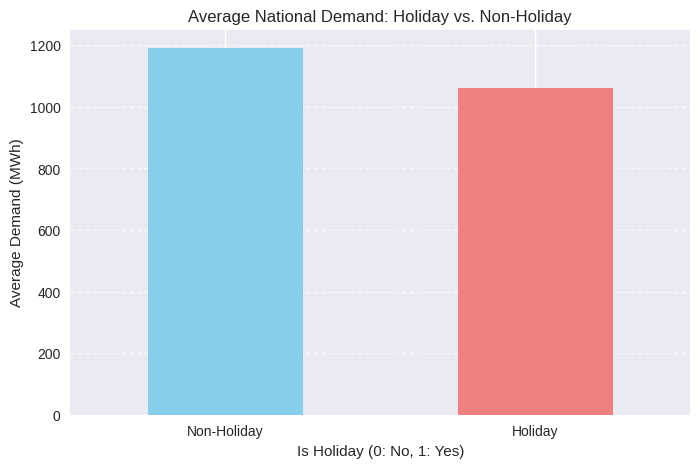

In [10]:
plt.figure(figsize=(8, 5))
holiday_effect.plot(kind='bar', color=['skyblue', 'lightcoral'])
plt.title('Average National Demand: Holiday vs. Non-Holiday')
plt.xlabel('Is Holiday (0: No, 1: Yes)')
plt.ylabel('Average Demand (MWh)')
plt.xticks(ticks=[0, 1], labels=['Non-Holiday', 'Holiday'], rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

**Hourly Demand Pattern**

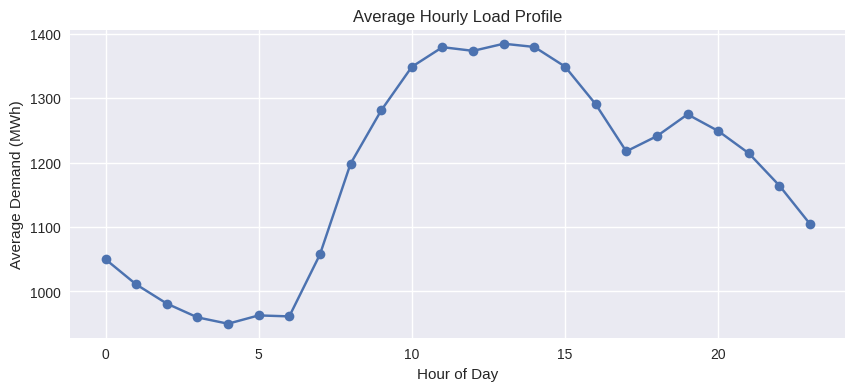

In [ ]:
df["hour"] = df.index.hour

hourly_avg = df.groupby("hour")["nat_demand"].mean()

plt.figure(figsize=(10,4))
hourly_avg.plot(marker="o")
plt.title("Average Hourly Load Profile")
plt.xlabel("Hour of Day")
plt.ylabel("Average Demand (MWh)")
plt.grid(True)
plt.show()

**Holiday & School Effect**

In [ ]:
holiday_effect = df.groupby("holiday")["nat_demand"].mean()
school_effect = df.groupby("school")["nat_demand"].mean()

holiday_effect, school_effect

(holiday
 0    1191.115235
 1    1060.086115
 Name: nat_demand, dtype: float64,
 school
 0    1170.292530
 1    1187.572329
 Name: nat_demand, dtype: float64)

**Preliminary Peak Definition**

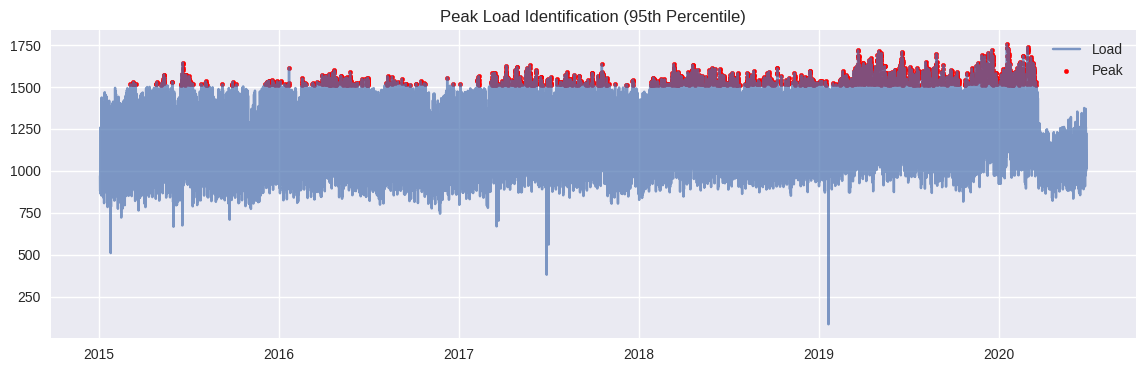

In [ ]:
peak_threshold = df["nat_demand"].quantile(0.95)
df["is_peak"] = df["nat_demand"] > peak_threshold

plt.figure(figsize=(14,4))
plt.plot(df["nat_demand"], label="Load", alpha=0.7)
plt.scatter(
    df[df["is_peak"]].index,
    df[df["is_peak"]]["nat_demand"],
    color="red",
    s=10,
    label="Peak"
)
plt.legend()
plt.title("Peak Load Identification (95th Percentile)")
plt.show()

### **📌 Conclusion**

Key Findings
* The dataset exhibits realistic operational characteristics with strong daily and weekly seasonality
* Demand behavior is strongly influenced by external factors such as weather, holidays, and school periods
* Holidays and school periods significantly affect feeder load
* A percentile-based statistical peak definition is feasible, interpretable, and suitable as a baseline

This EDA establishes a solid foundation for feeder demand forecasting and peak load detection, motivating the use of weather, calendar, and lagged features for short-term forecasting and reliable peak identification.